# Deep Autoencoder on MNIST Dataset

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras import backend as K
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))
K.get_session().run(tf.global_variables_initializer())

from tensorflow import set_random_seed
set_random_seed(2) #reproducibility

import sys
sys.path.append('../util/')
from util import plotProgress

Using TensorFlow backend.


## Load Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000,-1)
X_test = X_test.reshape(10000,-1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


## t-distributed Stochastic Neighbor Embedding
### Visualize high dimensional data with t-SNE

In [3]:
# from sklearn.manifold import TSNE

# X_tsne=X_test[:5000].reshape(5000,-1)
# tsne=TSNE(n_components=2,verbose=1,n_iter=500).fit_transform(X_tsne)
# cmap=['cyan','black','orange','red','blue','lime','azure','wheat','salmon','navy']
# fig,ax=plt.subplots()
# for i in range(10):
#     ax.scatter(tsne[y_test[:5000]==i,0],tsne[y_test[:5000]==i,1],
#                 edgecolors='black',c=cmap[i],
#                 label=str(i))
#     ax.annotate(str(i),(tsne[y_test[:5000]==i,0].mean(),tsne[y_test[:5000]==i,1].mean()),
#                bbox=dict(boxstyle="round", fc="w"))
# plt.legend()

## Declare Parameters

In [4]:
epochs = 100
batch = 256
latent_dim = 2
inters = [256,128,32,10]
optimizer = 'adam'

## Build Encoder

In [5]:
inputs=Input(shape = (X_train.shape[1],))
x = inputs
for inter in inters:
    x = Dense(inter,activation='relu')(x)
x = Dense(latent_dim)(x)
encoder = Model(inputs,x,name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 22        
Total params: 238,336
Trainable params: 238,336
Non-trainable params: 0
_________________________________________________________________


## Build Decoder

In [6]:
decode_in = Input(shape = (latent_dim,))
decode = decode_in
for inter in inters[::-1]:
    decode = Dense(inter,activation = 'relu')(decode)
decode = Dense(X_train.shape[1],activation = 'sigmoid')(decode)
decoder = Model(decode_in,decode)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_7 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_8 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_10 (Dense)             (None, 784)               201488    
Total params: 239,118
Trainable params: 239,118
Non-trainable params: 0
_________________________________________________________________


## Train Autoencoder

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.0749 - val_loss: 0.0559
Epoch 2/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0532 - val_loss: 0.0513
Epoch 3/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0492 - val_loss: 0.0471
Epoch 4/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0461 - val_loss: 0.0448
Epoch 5/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0441 - val_loss: 0.0433
Epoch 6/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0428 - val_loss: 0.0421
Epoch 7/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0418 - val_loss: 0.0416
Epoch 8/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0411 - val_loss: 0.0408
Epoch 9/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.0404 - val_loss: 0.0

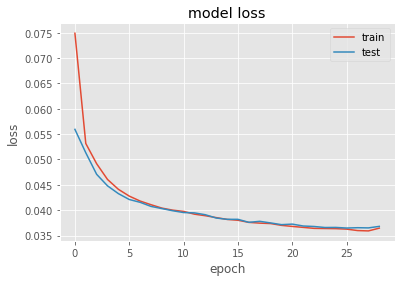

In [7]:
autoencoder = Model(inputs,decoder(encoder(inputs)))
autoencoder.compile(optimizer = optimizer,loss = 'mse')

es_cb = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'auto')
history = autoencoder.fit(X_train,X_train,
                        epochs = epochs,
                        batch_size = batch,
                        validation_data = (X_test,X_test),
                        callbacks = [es_cb])
# plot historical training process
plotProgress(history)

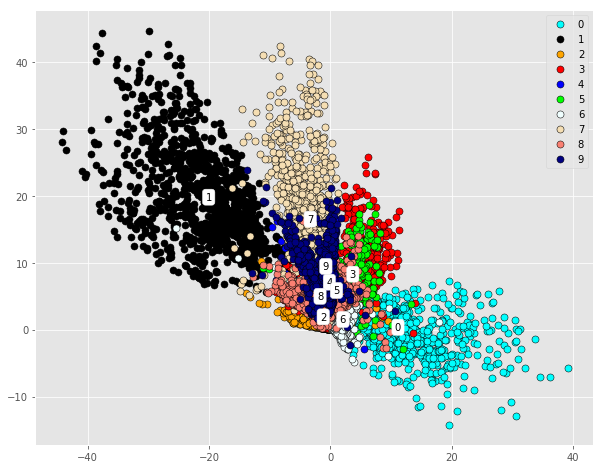

In [8]:
# get latent variables
lat = encoder.predict(X_test)
# plot scatter
cmap = ['cyan','black','orange','red','blue','lime','azure','wheat','salmon','navy']
fig,ax=plt.subplots(figsize = (10,8))
for i in range(10):
    ax.scatter(lat[y_test == i,0],lat[y_test == i,1],
               edgecolors = 'black',
               c = cmap[i],
               label = str(i),
               s = 50)
    ax.annotate(str(i),(lat[y_test == i,0].mean(),lat[y_test == i,1].mean()),
               bbox = dict(boxstyle = "round", fc = "w"))
plt.legend()
fig.savefig('images/clusters_256_128_32_10.png',bbox_inches='tight')

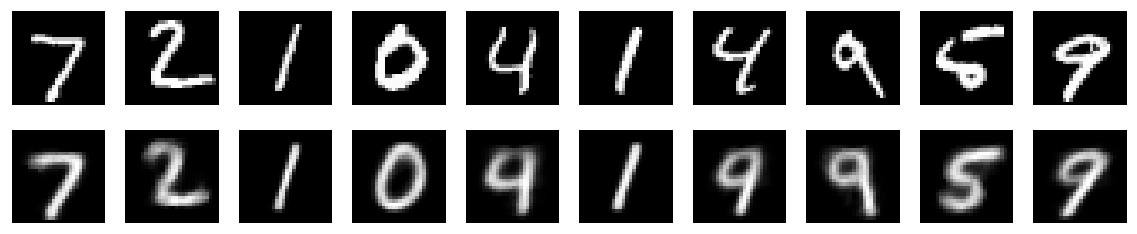

In [9]:
# get decoded digits
reconstructed = decoder.predict(lat)
# plot decoded
n = 10
row = 0
fig = plt.figure(figsize = (20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i + row * n].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i + row * n].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
fig.savefig('images/digits_256_128_32_10.png',bbox_inches='tight')